In [16]:
import random
import torch
import datetime
from dataset_utils import generate_dataset
import json
import matplotlib.pyplot as plt
from model import build_transformer
from config import get_config
from dataset import causal_mask, SequencesDataset
from torch.utils.data import random_split, DataLoader

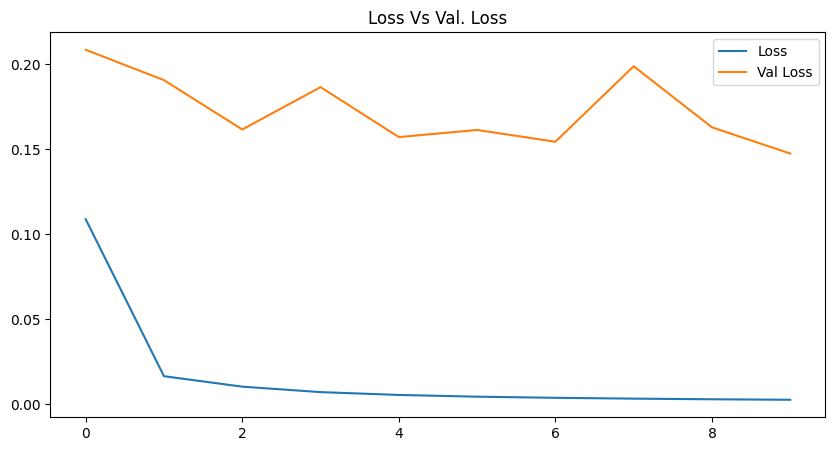

In [4]:
with open("EUR_USD_checkpoints/results.json", "r") as f:
    results = json.load(f)

results

plt.figure(figsize=(10,5))
plt.title("Loss Vs Val. Loss")
plt.plot(results["loss"], label="Loss")
plt.plot(results["val_loss"], label="Val Loss")
plt.legend()
plt.show()

In [11]:
config = get_config()
model = build_transformer(config["src_len"], config["tgt_len"], config["input_features"], config["y_size"], config["d_model"], config["N"], config["h"], config["dropout"], config["d_ff"])
state = torch.load("EUR_USD_checkpoints/algoTransformer_09.pt", map_location=torch.device('cpu'))
model.load_state_dict(state["model_state_dict"])

<All keys matched successfully>

In [14]:
X_raw, y_raw = generate_dataset(config["security"], config["provider"], config["src_len"], config["tgt_len"], config["start_year"], config["end_year"]) # generate raw dataset

c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyfinancialdata\get.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_data = price_data.append(pd.read_csv(csv_file, index_col=0))
c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyfinancialdata\get.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_data = price_data.append(pd.read_csv(csv_file, index_col=0))
c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyfinancialdata\get.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_data = price_data.append(pd.read_csv(csv_file, index_col=0))
c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyfinancialdata\g

In [24]:
full_ds = SequencesDataset(X_raw, y_raw, config["src_len"], config["tgt_len"]) # generate dataset object

# 80% training, 10% validation, 10% test
train_ds_size = int(0.8 * len(full_ds))
test_ds_size = int(0.1 * len(full_ds))
val_ds_size = len(full_ds) - train_ds_size - test_ds_size 

train_ds, test_ds, val_ds = random_split(full_ds, [train_ds_size, test_ds_size, val_ds_size], generator=torch.Generator().manual_seed(42))


train_dataloader = DataLoader(train_ds, batch_size=config["train_batch_size"], shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size = config["val_batch_size"], shuffle = True)
test_dataloader = DataLoader(test_ds, batch_size = 1, shuffle=True) # batch = 1 è strano in inferenza


def inference_decoding(model, source, source_mask, seq_len, device):

    # Precompute the encoder output and reuse it for every step
    encoder_output = model.encode(source, source_mask)  #(Batch, src_len, d_model)
    # Initialize the decoder input
    decoder_input = torch.zeros(encoder_output.shape[0], 1, 10).type_as(source).to(device)
    while True: # Autoregressive generation
        if decoder_input.size(1) == seq_len:
            break
        
        # build mask for target
        decoder_mask = causal_mask(decoder_input.size(1)).bool().to(device) 

        # calculate output
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

        # get next element in the sequence
        next_element = model.project(out[:, -1]) # è già sul device? in caso rimuovere il .to(device) che c'è sotto
        decoder_input = torch.cat([decoder_input, next_element.unsqueeze(1).to(device)], dim = 1) # da capire la dimensione di next_element
    
    return decoder_input.squeeze(0)


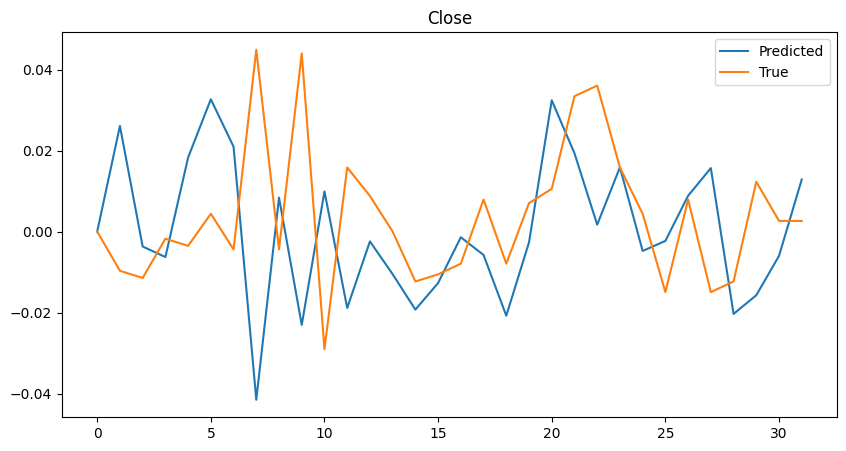

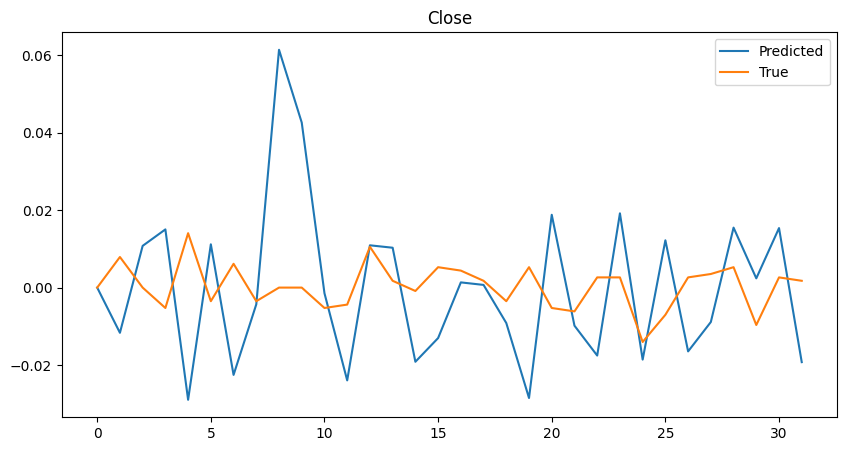

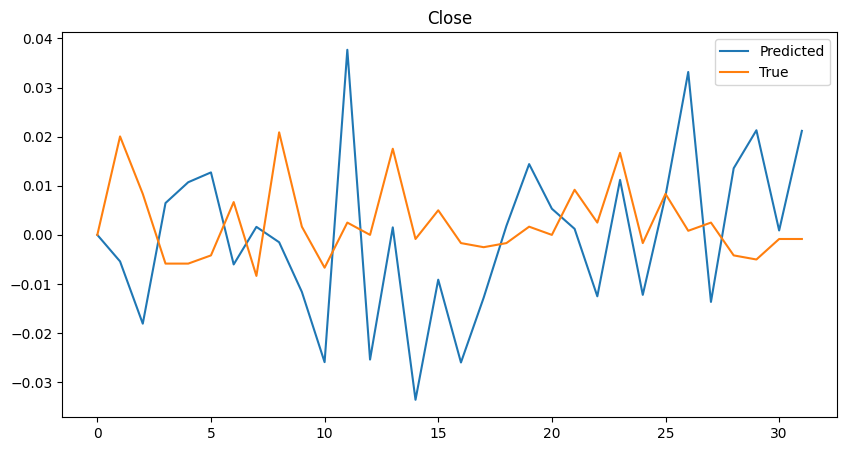

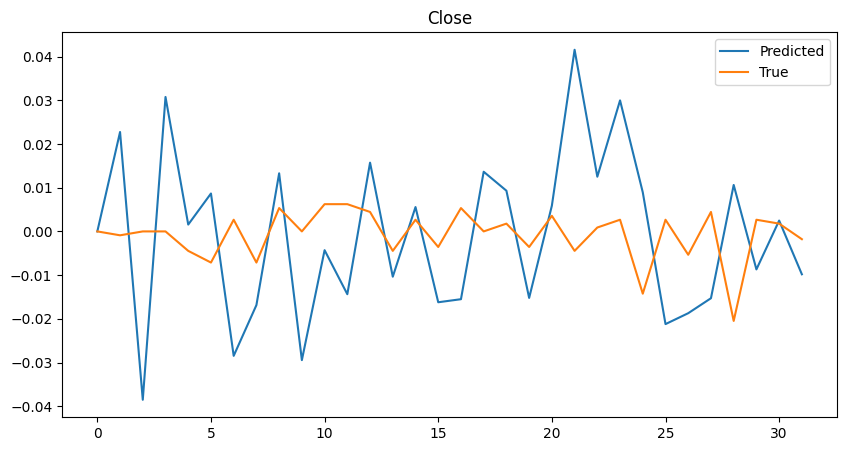

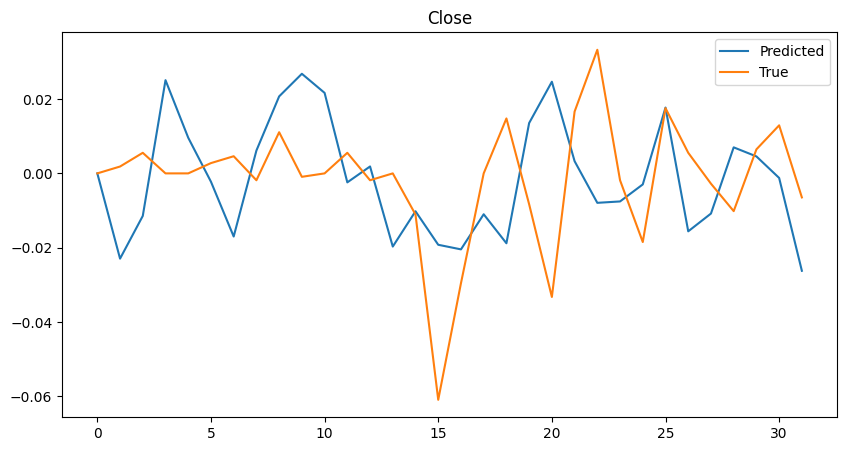

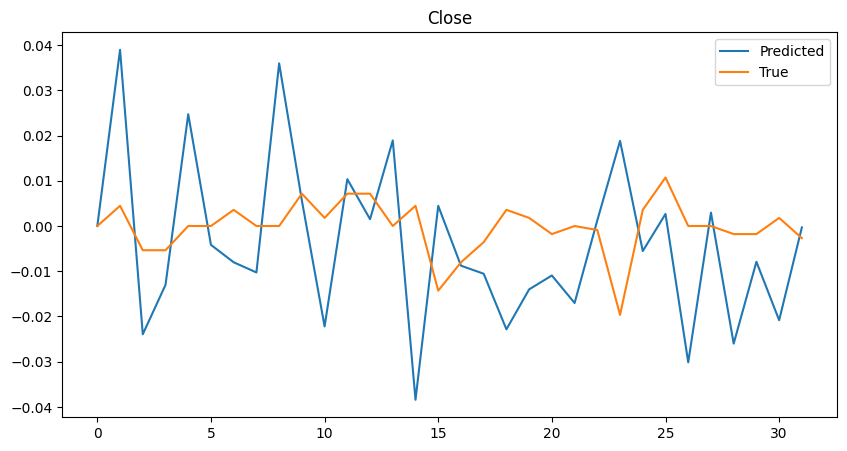

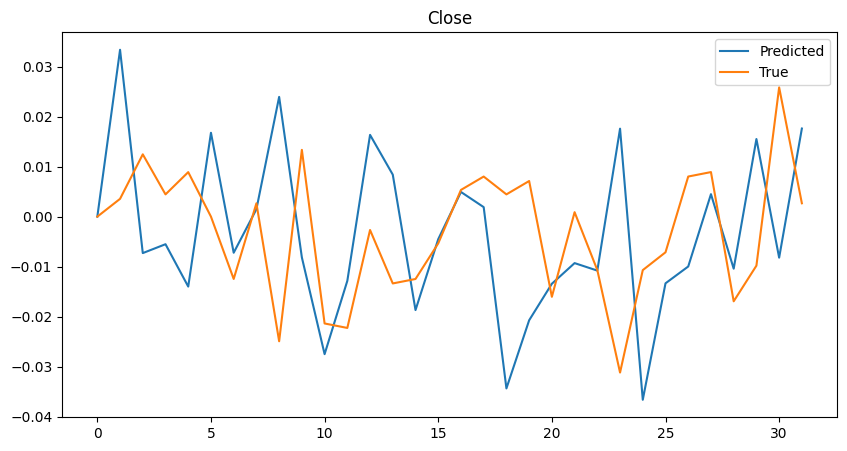

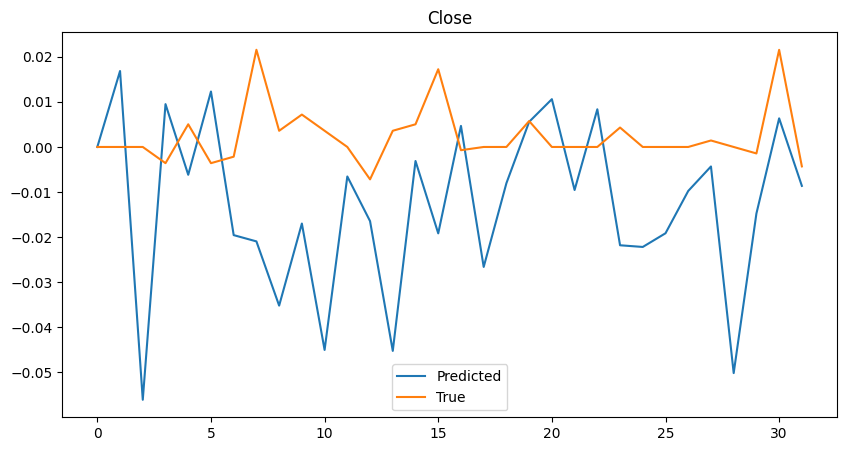

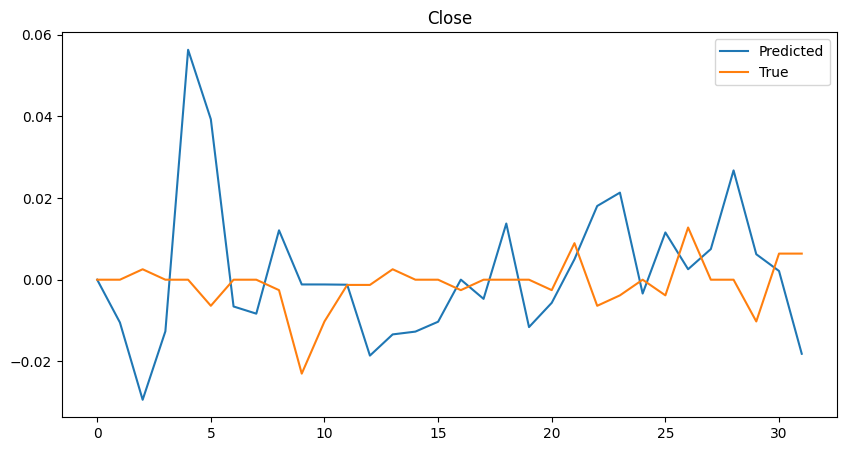

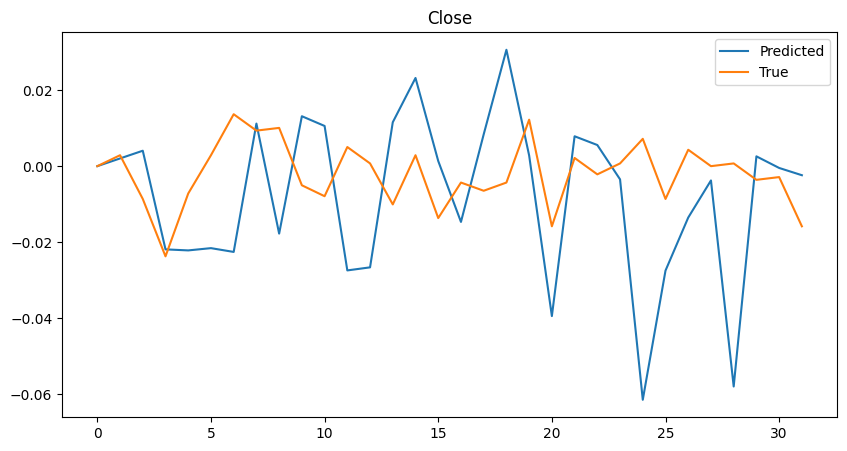

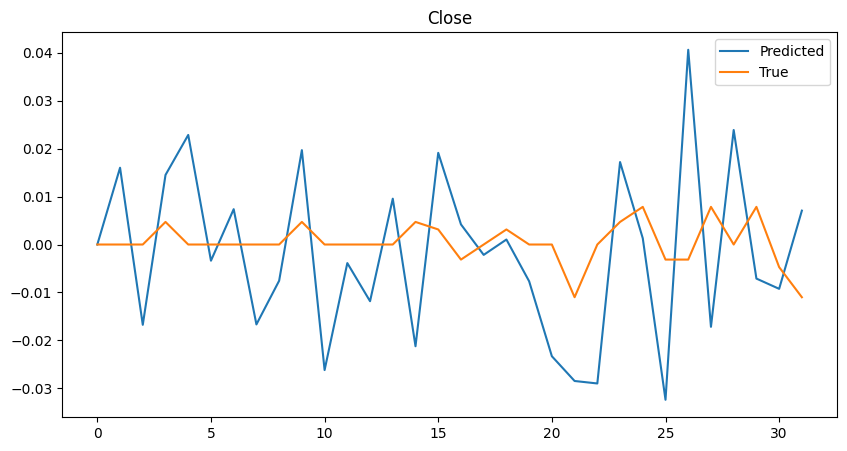

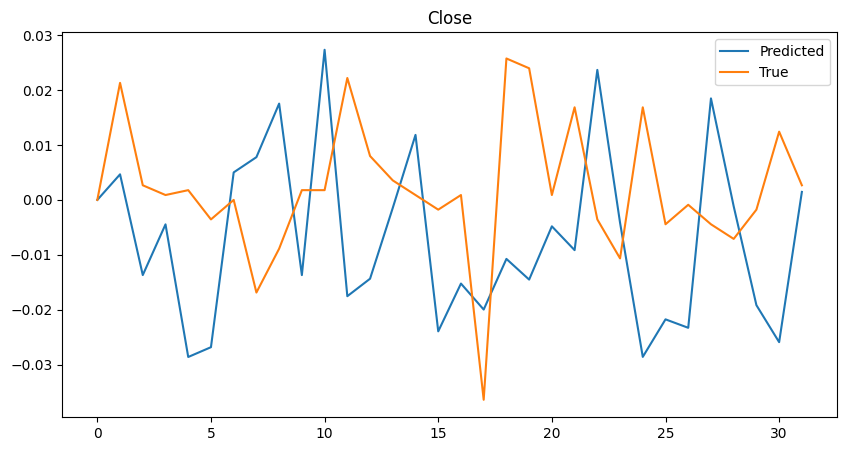

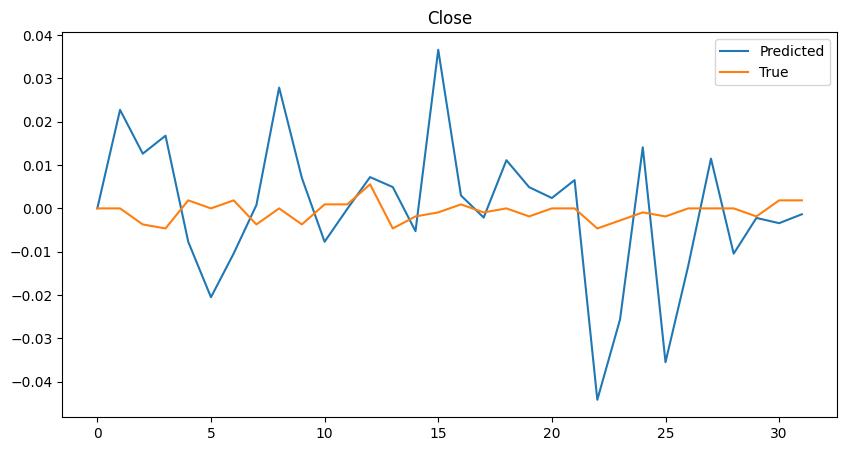

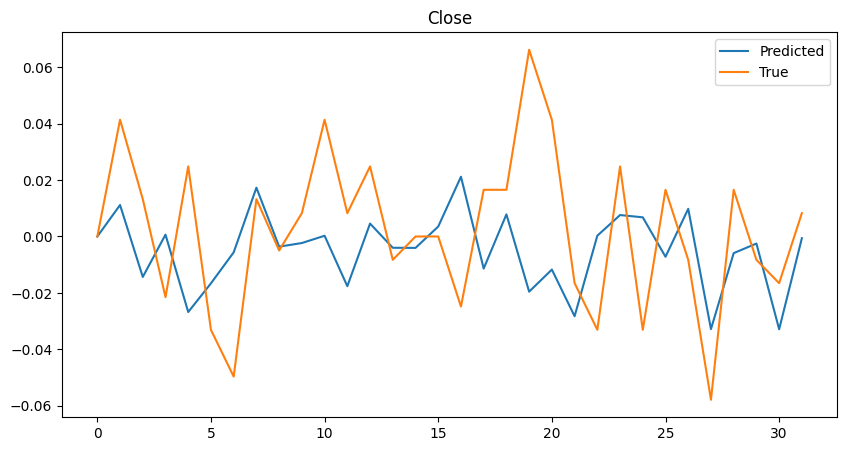

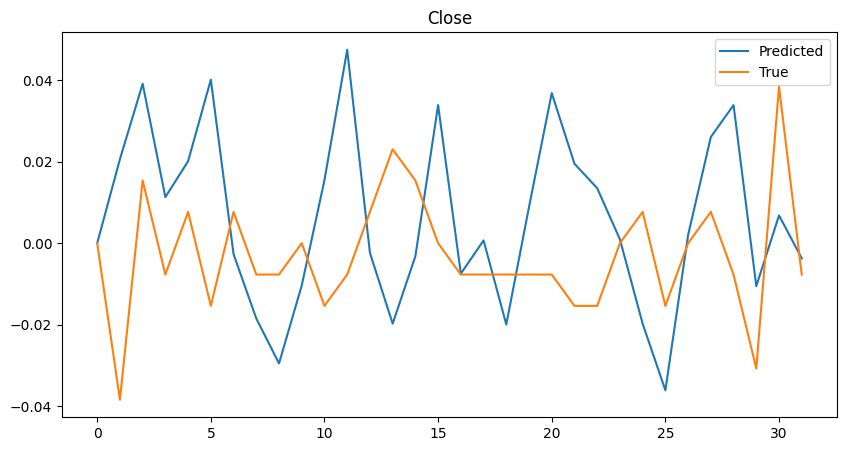

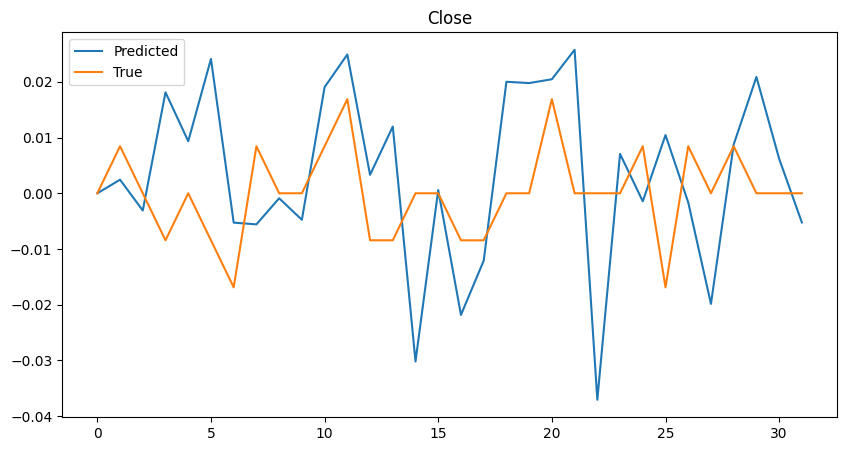

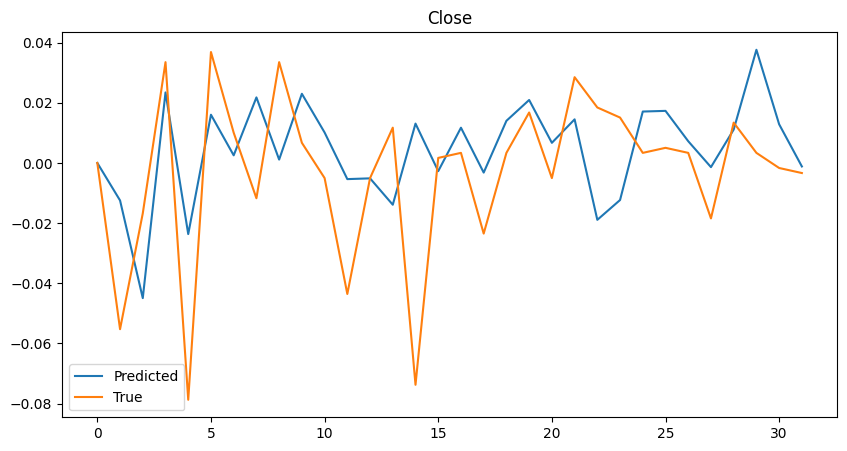

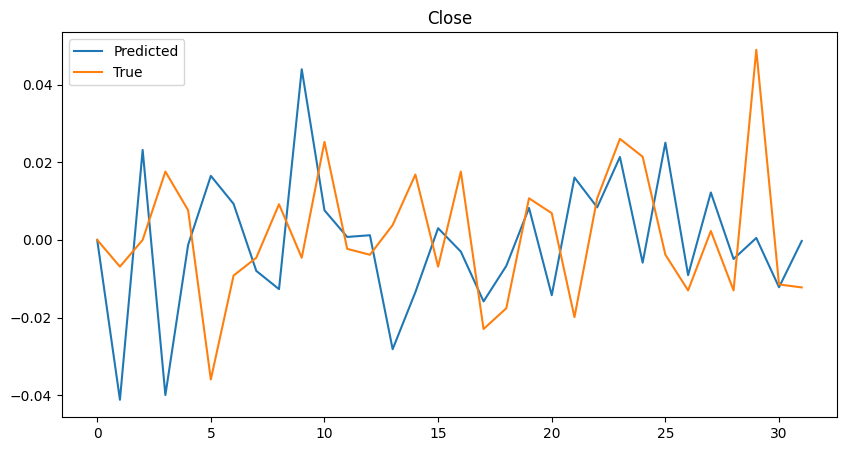

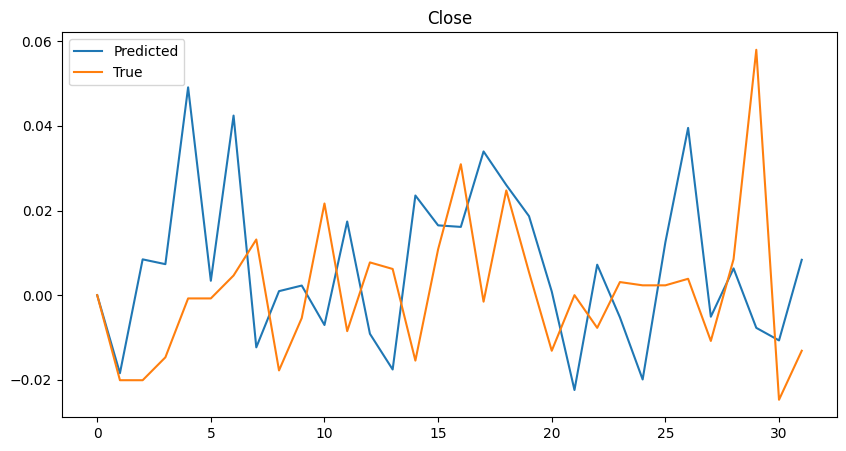

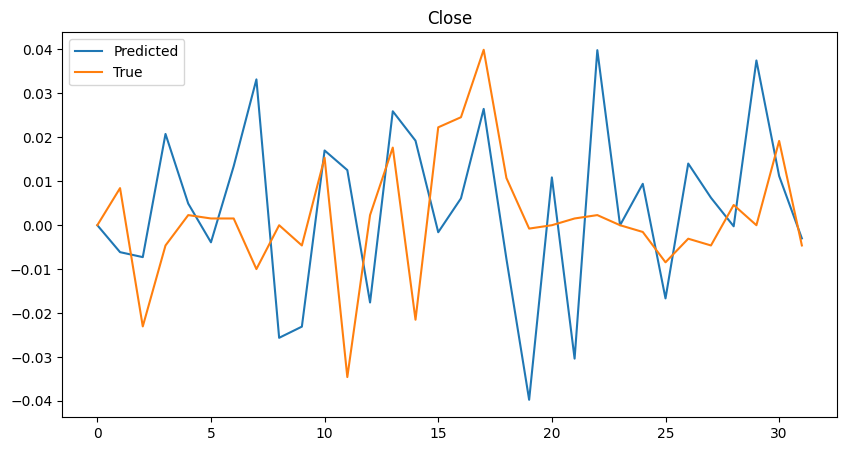

In [43]:
device = torch.device("cpu")
i = 0
for batch in test_dataloader:
    result = inference_decoding(model, batch["encoder_input"], None, config["tgt_len"], device)
    label = batch["label"]
    plt.figure(figsize=(10, 5))
    plt.plot(result[:, 0].detach().numpy(), label = "Predicted")
    plt.plot(label[0, :, 0], label = "True")
    plt.legend()
    plt.title("Close")
    plt.show()
    i+=1
    if i == 20:
        break

In [40]:
result[:, 0]

tensor([ 0.0000, -0.0139, -0.0169, -0.0095,  0.0194, -0.0356, -0.0229,  0.0158,
        -0.0133,  0.0205,  0.0335, -0.0153, -0.0031, -0.0036,  0.0160, -0.0052,
        -0.0345,  0.0009, -0.0137, -0.0063,  0.0054, -0.0082, -0.0068,  0.0011,
        -0.0107,  0.0638,  0.0237, -0.0036,  0.0428,  0.0215, -0.0022, -0.0473],
       grad_fn=<SelectBackward0>)

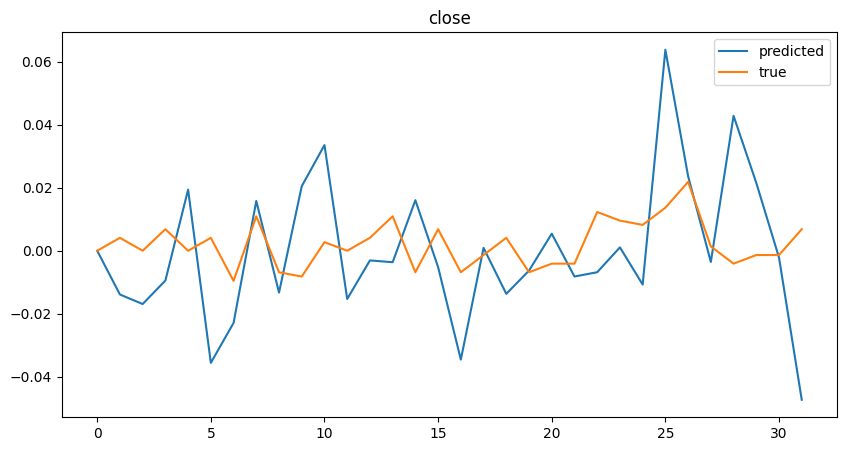

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(result[:, 0].detach().numpy(), label = "Predicted")
plt.plot(label[0, :, 0], label = "True")
plt.legend()
plt.title("Close")
plt.show()

In [11]:
y[:, 0, :]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

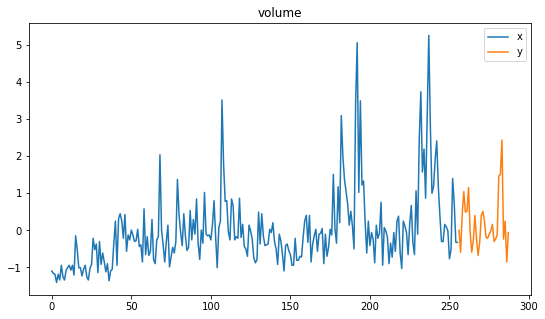

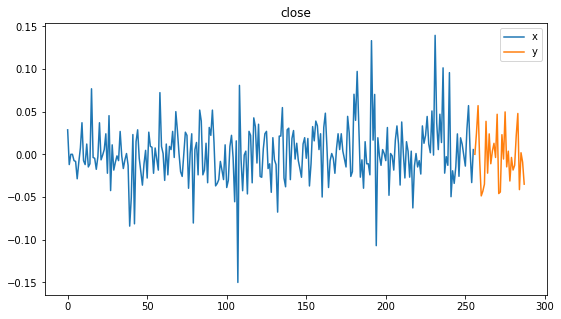

In [15]:
import matplotlib.pyplot as plt

n_seq = 269

src_len = X.shape[1]
tgt_len = y.shape[1]
plt.figure(figsize=(9, 5))
plt.plot(X[n_seq, :, 4], label = "x")
plt.plot([src_len + x for x in range(tgt_len)], y[n_seq, :, 4], label = "y")
plt.title("volume")
plt.legend()
plt.show()
plt.figure(figsize=(9, 5))
plt.plot(X[n_seq, :, 0], label = "x")
plt.plot([src_len + x for x in range(tgt_len)], y[n_seq, :, 0], label = "y")
plt.legend()
plt.title("close")
plt.show()

In [23]:
ciao = {}

def lol():
    ciao["ciao"] = "lol"
    ciao["ciao_2"] = "lol_2"
    pippo()

def pippo():
    ciao["ciao_2"] = "pippo_2"

lol()

ciao

{'ciao': 'lol', 'ciao_2': 'pippo_2'}

In [20]:
ciao

{'ciao': 'lol'}